In [1]:
# Import libraries
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import numpy as np

In [2]:
# For plot to appear in the notebook
%matplotlib inline 

# Import initial data

In [3]:
# Set the path to the original shapefile
admin1_shape="/media/tais/data/Dropbox/ULB/MAUPP/Coordination collaborateurs sur place/WP6_populeation_limitesadmin/Dakar_StLouis/Dakar_admin5_topological_clean/Dakar_units_core_cleaned.shp"
# Read the shapefile
gdf1 = gpd.read_file(admin1_shape)

In [4]:
# Keep only columns with population data (quantitative) that could be aggregated using a "grouby - sum" function
# Be carefull to keep the geometry column
gdf1 = gdf1.loc[:,['geometry','CONCESSION','MENAGE', 'HOMME', 'FEMME', 'POPULATION']] #Adapt the column names according to your own data

In [5]:
# Display the attribute table
gdf1.head()

,geometry,CONCESSION,MENAGE,HOMME,FEMME,POPULATION
0,"POLYGON ((250391.4934 1629353.1556, 250319.658...",310,343,1124,1142,2266
1,"POLYGON ((249750.3291999996 1629808.9005, 2497...",55,124,545,575,1120
2,"POLYGON ((250113.2289000005 1629602.2348, 2501...",92,123,542,508,1050
3,"POLYGON ((250155.7130000005 1629917.0689, 2501...",65,131,498,460,958
4,"POLYGON ((249878.8282000003 1630025.5766, 2498...",115,172,740,753,1493


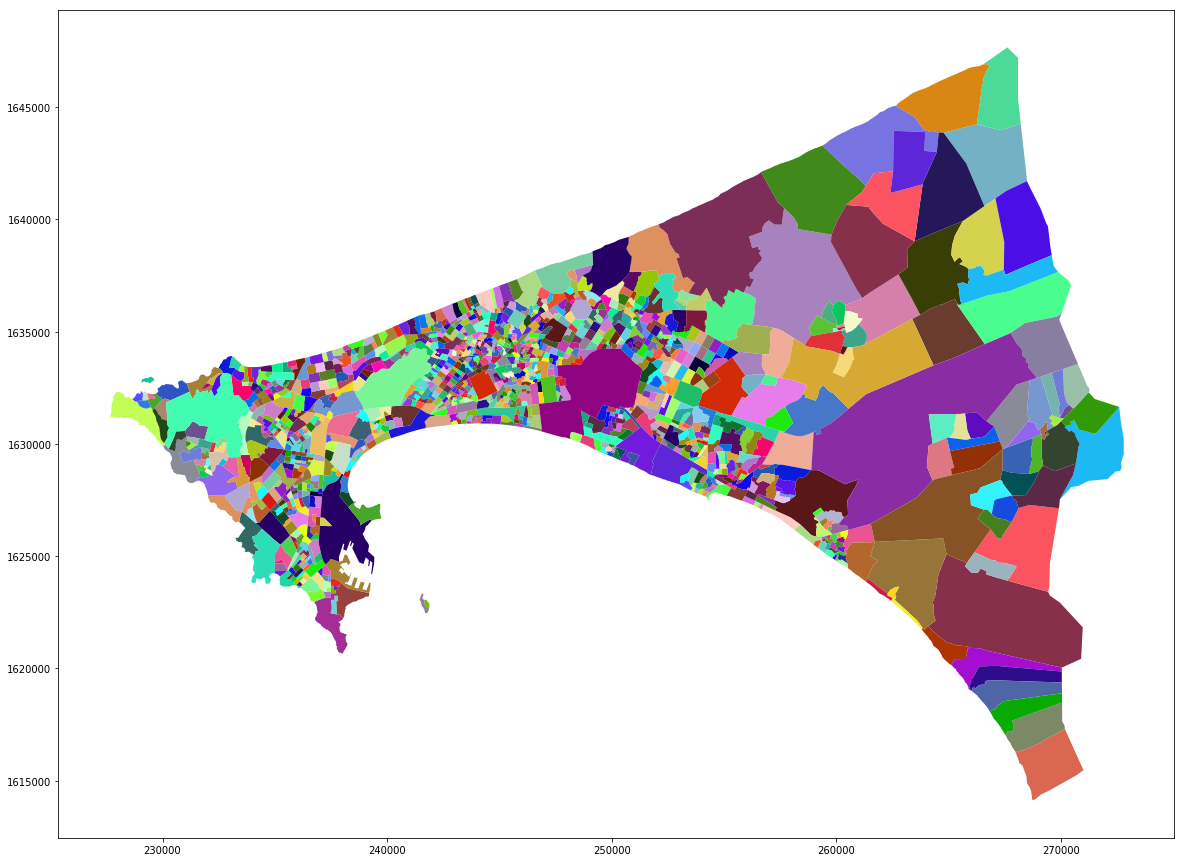

In [6]:
# A random colormap for matplotlib
cmap = mpl.colors.ListedColormap(np.random.rand(256,3))
# Display the shape
gdf1.plot(cmap=cmap, lw=0.2, figsize=(20,20))

# Kmeans clustering

In [7]:
def add_xy_columns(gdf1):
    # Add two columns to the attribute table with x (long) and y (lat)
    gdf1["x"] = gdf1.centroid.map(lambda p: p.x)
    gdf1["y"] = gdf1.centroid.map(lambda p: p.y)

In [8]:
def kmeans_on_geom_centroid(gdf1, n_clusters):
    # Getting the x/y values
    f1 = gdf1['x'].values
    f2 = gdf1['y'].values
    X = np.array(list(zip(f1, f2)))
    # Run Kmeans clustering
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=n_clusters).fit(X) # Here you can change the number of clusters you desire
    labels = kmeans.predict(X) # Getting the cluster labels
    # Joint results to the attribute table
    gdf1["cluster"] = labels

In [9]:
add_xy_columns(gdf1) # Add XY coordinates of the polygon centroid
kmeans_on_geom_centroid(gdf1, n_clusters=150) # Perform Kmeans clustering on XY columns
gdf1.head() # Display the attribute table

,geometry,CONCESSION,MENAGE,HOMME,FEMME,POPULATION,x,y,cluster
0,"POLYGON ((250391.4934 1629353.1556, 250319.658...",310,343,1124,1142,2266,250415.671612,1.629636e+06,54
1,"POLYGON ((249750.3291999996 1629808.9005, 2497...",55,124,545,575,1120,249673.014011,1.629686e+06,54
2,"POLYGON ((250113.2289000005 1629602.2348, 2501...",92,123,542,508,1050,249951.172254,1.629563e+06,54
3,"POLYGON ((250155.7130000005 1629917.0689, 2501...",65,131,498,460,958,249989.434381,1.629923e+06,54
4,"POLYGON ((249878.8282000003 1630025.5766, 2498...",115,172,740,753,1493,249696.999188,1.629966e+06,54


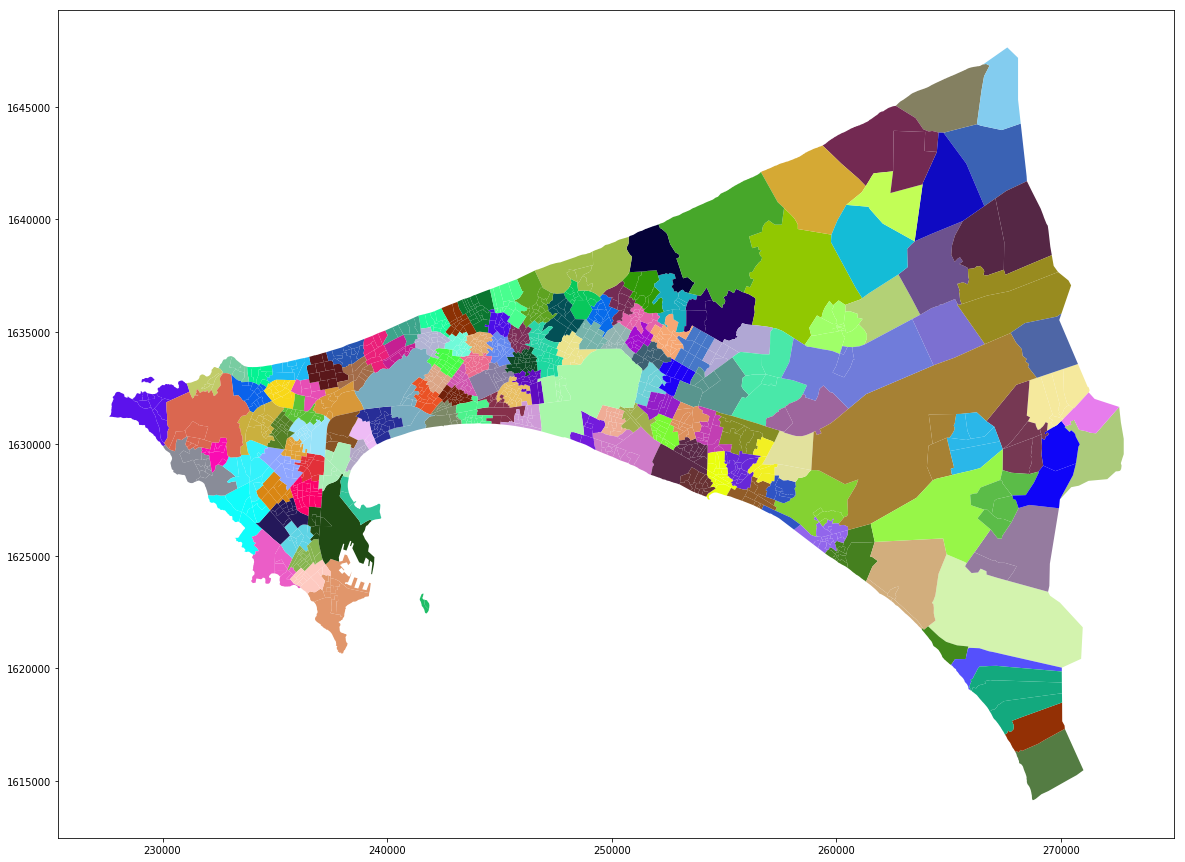

In [10]:
# Display the shape
gdf1.plot(column='cluster', cmap=cmap, lw=0.2, figsize=(20, 20))  #Adapt the column according to your own data

## Check if cluster members are disjoint from each other

In [11]:
def fix_disjoint_(gdf):
    ## Create a list of unique cluster values (sorted)
    cluster_list = list(gdf.cluster)
    cluster_list.sort()
    cluster_list = list(set(cluster_list)) # Use 'set' to get unique values

    ## Iterate through cluster list 
    found = False
    for cluster in cluster_list:
        a=gdf.loc[gdf1["cluster"]==cluster] # Create a temporary dataframe with units belong to the current cluster
        if len(a) > 1:  # Only continue if there are at least 2 rows in the dataframe
            for index, row in a.iterrows():
                geom_a = row.geometry  # Geometry of the current unit
                other_geom = a[~a.index.isin([index])].geometry # Geometry of the other units belonging to the cluster
                disconected_unit = other_geom.disjoint(geom_a).all() # Return True if all element of the pandas serie are True (all disconect)
                if disconected_unit:
                    found = True
                    new_cluster = gdf.cluster.max()+1
                    gdf.at[index, "cluster"] = new_cluster   # Assign new cluster value
                    print "Cluster %s had one unit disconected from the others that has been assign to new cluster (%s)"%(row.cluster,new_cluster)
    if not found:
        print "No problem found regarding to disjoint cluster members."

In [12]:
## Check and fix for issue of disjointed cluster members in the initial Kmeans results
fix_disjoint_(gdf1)

Cluster 16 had one unit disconected from the others that has been assign to new cluster (150)
Cluster 71 had one unit disconected from the others that has been assign to new cluster (151)


## Dissolve admin1 level to get admin0 level

In [13]:
def dissolve_admin1_to_admin0(gdf1):
    # Use dissolve function of Geopandas
    gdf0 = gdf1.dissolve(by='cluster', aggfunc='sum', as_index=False)
    gdf0.drop(['x', 'y'], axis=1, inplace=True) # Drop 'x' and 'y' columns since their sum do not have sense
    # Add count of admin1 unit in each cluster
    count_units = gdf1.dissolve(by='cluster', aggfunc='count', as_index=False)['x']
    gdf0['count'] = count_units
    return gdf0

In [14]:
# Dissolve admin1 level accordint to 'cluster' column to get admin0
gdf0 = dissolve_admin1_to_admin0(gdf1)
# Display the attribute table
gdf0.head()

,cluster,geometry,CONCESSION,MENAGE,HOMME,FEMME,POPULATION,count
0,0,"POLYGON ((248238.7878 1635040.687999999, 24821...",3054,4541,19495,18903,38400,12
1,1,"POLYGON ((234458.5937999999 1628238.721799999,...",4296,7808,19137,20162,39301,9
2,2,"POLYGON ((260526.7045 1624465.8401, 260484.240...",801,1530,7652,7462,15114,11
3,3,"POLYGON ((252426.2172999997 1629902.4274, 2525...",1555,1879,6169,6688,12858,16
4,4,"POLYGON ((242947.6977000004 1633032.6029, 2429...",3520,7318,26795,26399,53195,19


## Fix issues of clusters compouned by 1 unit only

The strategy implemented here is to merge 1unit-clusters with its neighboring cluster that is compouned by the smallest number of iriginal administratives units.

In [15]:
# Declare a function that check how many cluster are composed of only have one unit 
def check_remaining_single_cluster(df):
    global count_dict
    count_dict={x.cluster:x['count'] for i,x in df.iterrows()}
    number_single_cluster = len(df.loc[df['count']<2])
    return number_single_cluster

In [16]:
# Declare a function that add a "NEIGHBORS" column with id of neighboring clusters 
def find_neighbors(gdf, unique_id="cluster"):
    gdf["NEIGHBORS"] = None  # Add empty NEIGHBORS column
    for index, unit in gdf.iterrows():   
        # get 'not disjoint' countries
        neighbors = gdf[~gdf.geometry.disjoint(unit.geometry)][unique_id].tolist()
        if len(neighbors)==1:
            # Get the geom of the centroid of origin (the current row) and of the destination (all the other points)
            origin_geom = gdf0.iloc[index].geometry.centroid
            destin_geom = gdf0[~gdf0.index.isin([index])].geometry.centroid
            tmp_df = pd.DataFrame(gdf0.loc[:,"cluster"])
            dist_min = pd.DataFrame(destin_geom.geometry.distance(origin_geom))
            tmp_df['dist']=dist_min
            nearest_cluster = int(tmp_df.loc[tmp_df['dist']==float(tmp_df['dist'].min())]['cluster'])
            neighbors = [nearest_cluster]
        # remove own name from the list
        neighbors = [str(Id) for Id in neighbors if unit[unique_id] != Id]
        # add names of neighbors as NEIGHBORS value
        gdf.at[index, "NEIGHBORS"] = ", ".join(neighbors)

In [17]:
# Declare a function that return the id of the smallest neighborhing cluster 
def check_smallest_cluster(_dict, _list):
        neighbor_id=[int(x) for x in _list.split(',')]
        candidate_value=_dict[neighbor_id[0]]
        candidate_id=neighbor_id[0]
        for x in neighbor_id[1:]:
            if _dict[x] < candidate_value:
                candidate_value=_dict[x]
                candidate_id=x
        return candidate_id

In [18]:
find_neighbors(gdf0) # Add/update the list of neighbors of each cluster
gdf0.head() # Display the attribute table

,cluster,geometry,CONCESSION,MENAGE,HOMME,FEMME,POPULATION,count,NEIGHBORS
0,0,"POLYGON ((248238.7878 1635040.687999999, 24821...",3054,4541,19495,18903,38400,12,"17, 37, 62, 92, 107, 111"
1,1,"POLYGON ((234458.5937999999 1628238.721799999,...",4296,7808,19137,20162,39301,9,"9, 27, 63, 97, 103, 125, 132, 136"
2,2,"POLYGON ((260526.7045 1624465.8401, 260484.240...",801,1530,7652,7462,15114,11,"13, 32, 34, 102"
3,3,"POLYGON ((252426.2172999997 1629902.4274, 2525...",1555,1879,6169,6688,12858,16,"31, 52, 54, 60, 88, 93"
4,4,"POLYGON ((242947.6977000004 1633032.6029, 2429...",3520,7318,26795,26399,53195,19,"43, 69, 81, 110, 120, 127"


In [19]:
## Minimum original units per cluster 
min_units = 2

## As long as there remain issues (clusters with only one admin unit) merge it with the neighboring cluster that have the smallest number of admin units
current_number_clusters = len(gdf0)
remaining = check_remaining_single_cluster(gdf0)  # remaining variable takes number of cluster remaining with only 1 original unit
if remaining == 0:
    print "The admin 1 layer contains %s clusters."%current_number_clusters
    print "Nothing to fix: All clusters are compouned by at least %s original administrative units"%min_units
else:
    print "Fixing issue(s)..."
    while remaining > 0:
        for index, unit in gdf0.iterrows():   
            if unit['count'] < min_units:
                list_neighbors=unit.NEIGHBORS
                candidate_cluster=check_smallest_cluster(count_dict,list_neighbors)
                print "   -> cluster %s only have 1 original unit and will be merge with cluster %s"%(unit['cluster'],candidate_cluster)
                # Update the value of 'cluster' column (result of Kmeans) with the new candidate cluster
                gdf1['cluster'] = gdf1.cluster.apply(lambda x: candidate_cluster if x == unit['cluster'] else x)  
                break  # Allow to operate dissolving one by one
        # Dissolve according to the updated cluster membership
        gdf0 = dissolve_admin1_to_admin0(gdf1)
        find_neighbors(gdf0)
        remaining = check_remaining_single_cluster(gdf0)
        print 'remaining issues : %s'%remaining
    current_number_clusters = len(gdf0)
    print "\n**-_-_-_-_-_-_-_-_-_-_-_-_-_-_**"
    print "\nThe admin 1 layer contains %s clusters."%current_number_clusters
    print "\nAll issues have been removed: All clusters are compouned by at least %s original administrative units"%min_units    

Fixing issue(s)...
   -> cluster 34 only have 1 original unit and will be merge with cluster 117
remaining issues : 22
   -> cluster 44 only have 1 original unit and will be merge with cluster 101
remaining issues : 20
   -> cluster 51 only have 1 original unit and will be merge with cluster 70
remaining issues : 18
   -> cluster 67 only have 1 original unit and will be merge with cluster 79
remaining issues : 16
   -> cluster 68 only have 1 original unit and will be merge with cluster 137
remaining issues : 14
   -> cluster 84 only have 1 original unit and will be merge with cluster 104
remaining issues : 12
   -> cluster 89 only have 1 original unit and will be merge with cluster 148
remaining issues : 10
   -> cluster 116 only have 1 original unit and will be merge with cluster 121
remaining issues : 8
   -> cluster 123 only have 1 original unit and will be merge with cluster 70
remaining issues : 7
   -> cluster 129 only have 1 original unit and will be merge with cluster 25
remain

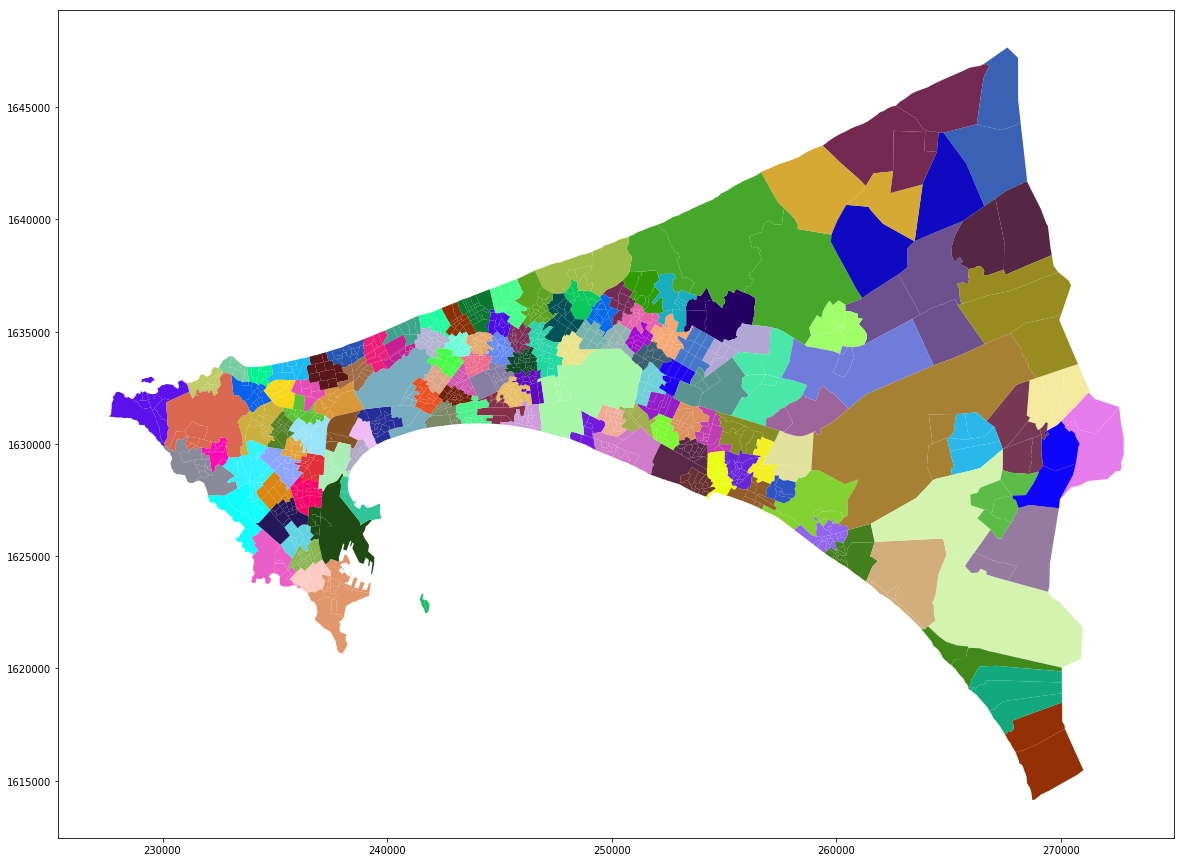

In [20]:
# Display the shape
gdf1.plot(column='cluster', cmap=cmap, lw=0.2, figsize=(20, 20))  #Adapt the column according to your own data

### Display final result - Admin 0 borders

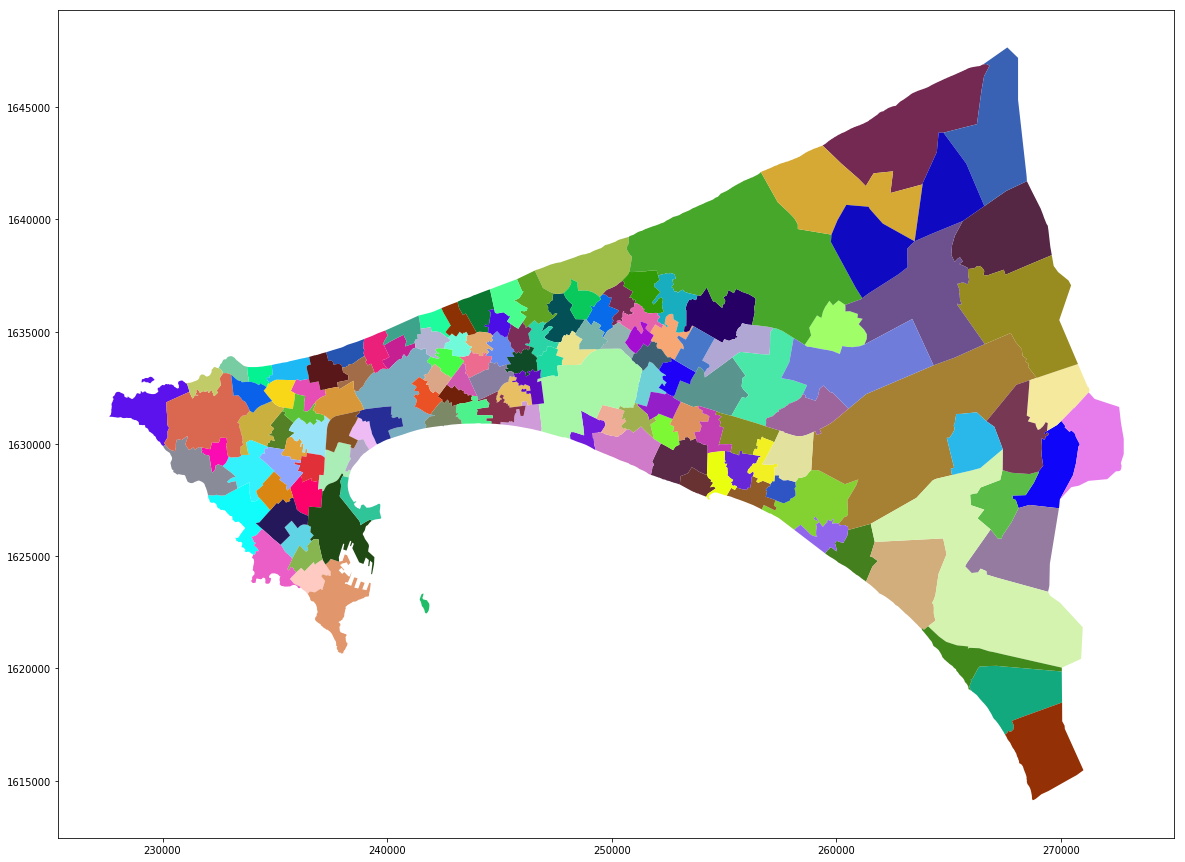

In [21]:
# Display the shape
gdf0.plot(column='cluster', cmap=cmap, lw=0.2, figsize=(20, 20))  #Adapt the column according to your own data

# Export admin1 shapefile

In [22]:
# Set the path to the shapefile to be created
shape_export = '/media/tais/My_Book_1/MAUPP/Traitement/Population_modelling_dasymetry/Results/Dakar/admin0.shp'
# Export
gdf0.to_file(driver='ESRI Shapefile',filename=shape_export)